In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q /content/drive/MyDrive/datasets/Tomato.zip

In [4]:
# initialize the data generator
datagen = ImageDataGenerator(validation_split=0.1)

# get training data
train_ds = datagen.flow_from_directory(
    '/content/Tomato/Model_1_Healthy_Vs_Blight',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training',  # set as training data
    seed=42
)

# get validation data
val_ds = datagen.flow_from_directory(
    '/content/Tomato/Model_1_Healthy_Vs_Blight',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # set as validation data
    seed=42
)

Found 3495 images belonging to 2 classes.
Found 388 images belonging to 2 classes.


In [5]:
train_ds.class_indices

{'Tomato_Blight': 0, 'Tomato_healthy': 1}

In [6]:
model1 = Sequential()

model1.add(layers.Input(shape=(256,256,3)))
model1.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Dense Layers
model1.add(Dense(64, activation='relu'))

# Output
model1.add(Dense(1, activation='sigmoid'))

model1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy']
)

In [7]:
model1.input_shape

(None, 256, 256, 3)

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [9]:
h = model1.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
110/110 [==============================] - 25s 119ms/step - loss: 0.3655 - accuracy: 0.8715 - val_loss: 0.1547 - val_accuracy: 0.9381
Epoch 2/5
110/110 [==============================] - 13s 117ms/step - loss: 0.0724 - accuracy: 0.9765 - val_loss: 0.0470 - val_accuracy: 0.9845
Epoch 3/5
110/110 [==============================] - 15s 132ms/step - loss: 0.0670 - accuracy: 0.9731 - val_loss: 0.1629 - val_accuracy: 0.9407
Epoch 4/5
110/110 [==============================] - 13s 121ms/step - loss: 0.0472 - accuracy: 0.9840 - val_loss: 0.0229 - val_accuracy: 0.9923
Epoch 5/5
110/110 [==============================] - 12s 112ms/step - loss: 0.0283 - accuracy: 0.9900 - val_loss: 0.0510 - val_accuracy: 0.9820


Prompted CHAT-GPT 4 to help grab the labels information from the validation dataset and get it into a numpy array, so that we can use that to make a confusion matrix.

In [10]:
def get_data(generator):
    data_list = []
    labels_list = []
    batch_index = 0

    while batch_index <= generator.batch_index:
        data, labels = generator.next()
        data_list.extend(data)
        labels_list.extend(labels)
        batch_index += 1

    # Return as numpy arrays
    return np.array(data_list), np.array(labels_list)

val_data, val_labels = get_data(val_ds)

In [11]:
predictions = model1.predict(val_data)

13/13 [==============================] - 0s 27ms/step


In [12]:
y_pred_classes = np.round(predictions).flatten()
y_true_classes = val_labels

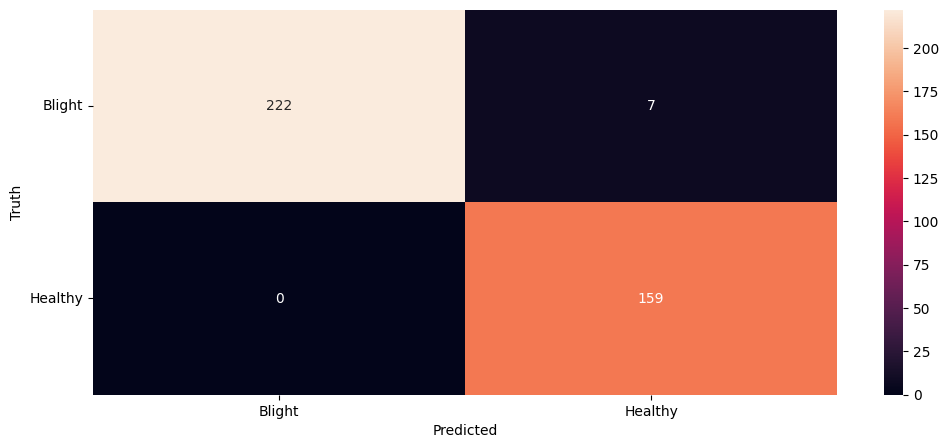

In [13]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [14]:
def scores(y_test, preds):
    '''
    This function will be used to evaluate the scores of our model.
    '''
    print(f'Recall Score: {recall_score(y_test, preds)}')
    print(f'F1 score: {f1_score(y_test, preds)}')
    print(f'precision score: {precision_score(y_test, preds)}')
    print(f'accuracy score: {accuracy_score(y_test, preds)}')

In [15]:
scores(y_true_classes, y_pred_classes)

Recall Score: 1.0
F1 score: 0.9784615384615385
precision score: 0.9578313253012049
accuracy score: 0.9819587628865979


In [16]:
metrics.binary_accuracy(y_true_classes, y_pred_classes, threshold=0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.98195875>

In [17]:
model1.save('TomatoModel.h5')